In [1]:
import graph_load
import graph_model
import torch
from sklearn.metrics import accuracy_score, recall_score, precision_score, fbeta_score, f1_score, roc_curve, RocCurveDisplay, auc
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = 'cuda'
data_dir = './tnf/'
#data_dir = './yfp/'


In [3]:
def test(test_loader, model):
    model.eval()
    pred_all = []
    target_all = []
    out_all = []

    with torch.no_grad():
        for data in test_loader:
            data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            out_all.append(out)
            #pred = out.argmax(dim=1)
            #pred_all.append(pred)
            target_all.append(data.y)

        out_all = torch.cat(out_all, dim=0)
        #pred_all = torch.cat(pred_all, dim=0)
        target_all = torch.cat(target_all, dim=0)

    return target_all, out_all

print(f"Test acc: {accuracy_score(target_test.cpu(), pred_test.cpu())}")
print(f"Test prec: {precision_score(target_test.cpu(), pred_test.cpu())}")
print(f"Test rec: {recall_score(target_test.cpu(), pred_test.cpu())}")
print(f"Test F1: {f1_score(target_test.cpu(), pred_test.cpu())}")  
print(f"Test F2: {fbeta_score(target_test.cpu(), pred_test.cpu(), beta=2.0)}")
print(f"Total: {target_test.cpu().shape}, total positive: {target_test.cpu().sum()}")
print(f"Wrongly predicted: {wrong_pred}, wrongly predicted positive: {wrong_pos}") 


In [5]:
targets = []
outs = []
preds = []
for split in range(5):
    model = graph_model.GCNMid().to(device)
    #train_loader, val_loader, test_loader = graph_load.LoadGraphData(data_dir, 256, 256, split)
    test_loader = graph_load.TestData(data_dir, 256)
    model.cuda()
    model.load_state_dict(torch.load(f'./6-7-0-yfp_split_{split}.pt'))
    target_test, out_test = test(test_loader, model)
    _, pred_test = torch.max(out_test.data, 1)
    out_test = torch.nn.functional.softmax(out_test.data, 1)[:, 1]
    wrong_pos = (target_test * (target_test != pred_test)).sum()
    wrong_pred = ((target_test != pred_test)).sum()
    targets.append(target_test.cpu())
    outs.append(out_test.cpu())
    preds.append(pred_test.cpu())

In [6]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

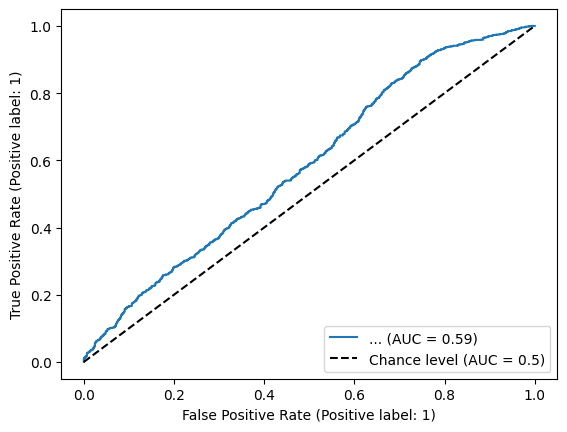

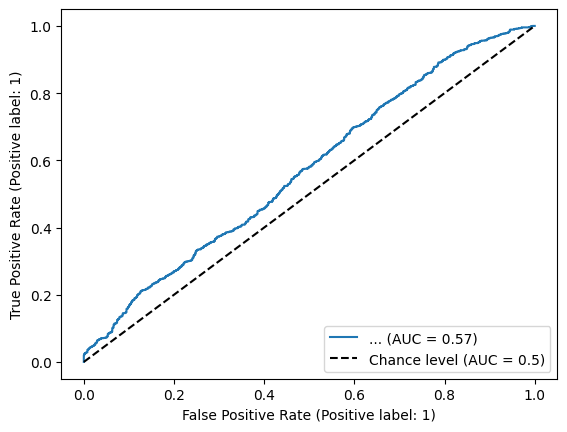

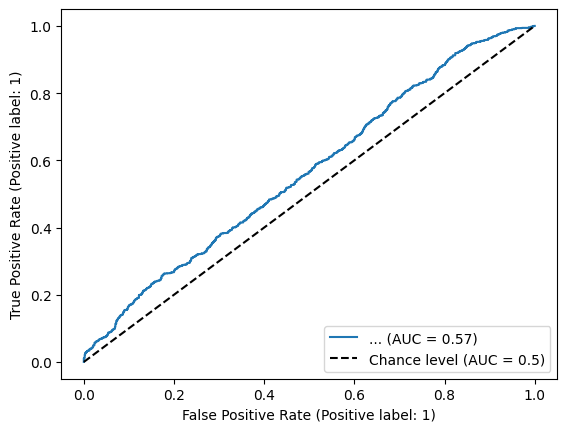

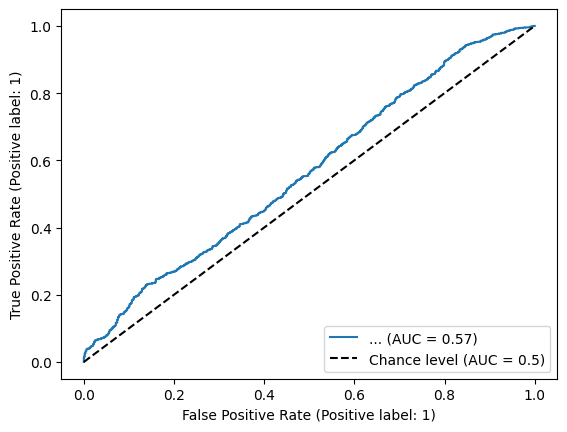

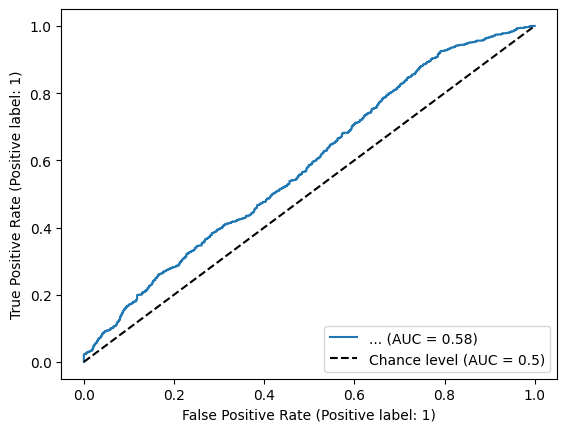

In [7]:
for split in range(5):
    display = RocCurveDisplay.from_predictions(targets[split], outs[split], name="...", plot_chance_level=True)
    interp_tpr = np.interp(mean_fpr, display.fpr, display.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(display.roc_auc)

In [8]:
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

In [9]:
chance_x = np.linspace(0, 1, 100)
chance_y = np.linspace(0, 1, 100)

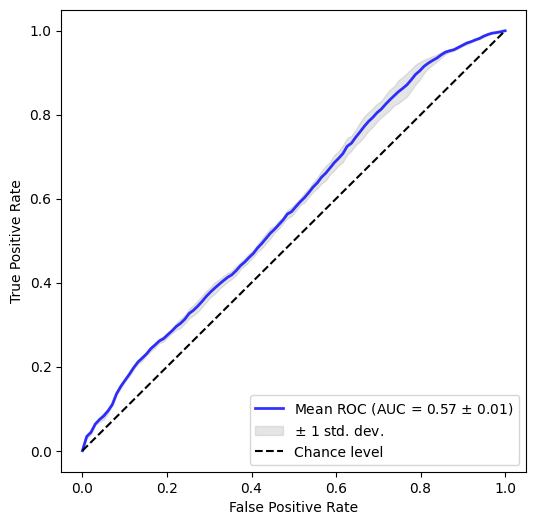

In [10]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.plot(chance_x, chance_y, linestyle='dashed', color='black', label='Chance level')

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend(loc="lower right")
plt.show()